# Predicting Loan Eligibility for Dream Housing Finance company

- This challenge is aimed at automating the loan eligibility process (variable: *loan status*) based on customer information, such as gender, marital status, education, income, etc. 
- The dataset & challenge come from this website: https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/#ProblemStatement

### IMPORT LIBRARIES

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn

In [2]:
import missingno as msno

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### LOAD THE DATA

In [4]:
train = pd.read_csv("train_.csv")
test = pd.read_csv("test_.csv")

In [5]:
train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


### DATA OBSERVATIONS

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


- We are dealing with object, integer and float data types.
Not all of the columns are filled in - there is a number of missing values.

### HANDLING MISSING VALUES

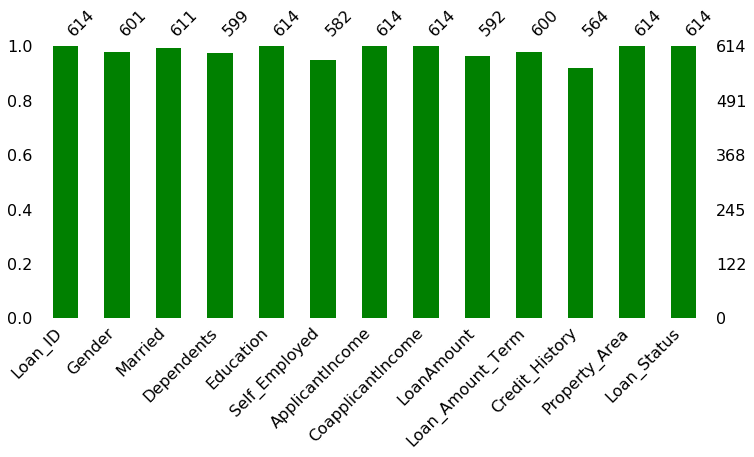

In [7]:
# plot the number of non-null values in the dataframe
msno.bar(train, figsize = (12,5), color = 'green')

In [8]:
print(train.isnull().sum())
print(train.isnull().sum()/train.shape[0])

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64
Loan_ID              0.000000
Gender               0.021173
Married              0.004886
Dependents           0.024430
Education            0.000000
Self_Employed        0.052117
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.035831
Loan_Amount_Term     0.022801
Credit_History       0.081433
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64


- Looks like the highest number of missing values is in the "Credit_History" column, but still the number represents less than 10% of all values in the dataframe, so we can safely drop the missing values. 
- Data imputation techniques can be thought of at a later stage, should the model perform badly.

In [9]:
train.dropna(inplace=True, axis=0)

### DATA MODIFICATIONS

- To facilitate further analysis, we need to convert some of the objects into floats or integers (such as Marital status, Gender and Education). We can use Label Encoding for that, as the features are binary. 
- Property_Area column is ordinal in a sense (moving from rural to urban), so we can label-encode it as well. 

In [10]:
cols_to_encode = ['Gender', 'Married', 'Self_Employed', 'Loan_Status', 'Education', 'Property_Area']

train[cols_to_encode]=train[cols_to_encode].apply(LabelEncoder().fit_transform)

- We do not need the loan id column for the purposes of our analysis, so let's drop it.

In [11]:
train.drop(['Loan_ID'],axis=1, inplace = True)

- Let's take a look at the "Dependents" column - it is not numeric either. 
- There are values corresponding to "3+" which we can safely replace with just 3, as we do not have any extra information.

In [12]:
train['Dependents'].value_counts()

0     274
2      85
1      80
3+     41
Name: Dependents, dtype: int64

In [13]:
train['Dependents'] = train['Dependents'].str.replace("+", "").astype(float)

In [14]:
train['Dependents'].value_counts()

0.0    274
2.0     85
1.0     80
3.0     41
Name: Dependents, dtype: int64

### DATA EXPLORATION

Let us:
- 1) try to understand how features are correlated with one another and with the target variable;
- 2) identify any abnormal values (outliers) in the dataset.

In [15]:
corr_matrix=train.corr().abs()

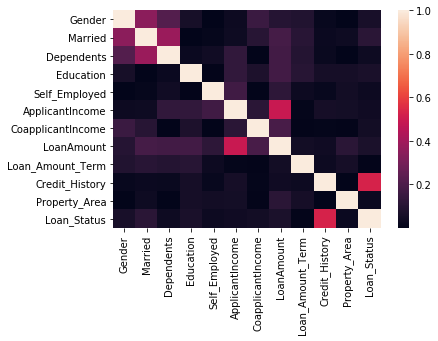

In [16]:
sns.heatmap(corr_matrix)

- 'Credit_History' is somewhat correlated with the target variable ("Loan_Status"); 
- There is also a correlation between applicant income and loan amount.

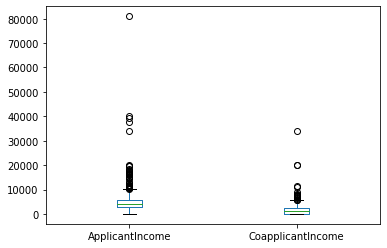

In [17]:
cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

train[cols[:2]].plot(kind='box')
plt.show()

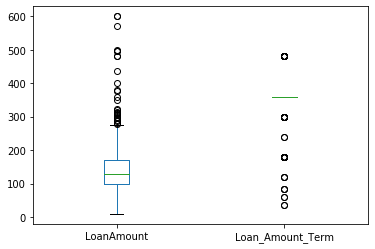

In [18]:
train[cols[-2:]].plot(kind='box')
plt.show()

- Looks like there are a few outliers in the Applicant and Coapplicant income category: people earning above 80,000 and 30,000, respectively. The rest of the data looks fine and there are no problems like "negative income".
- Let's leave the outliers in the database for now and decide on whether dropping the observations would increase model accuracy at a later stage. 

In [19]:
train_copy = train.copy()
train_copy.set_index('Loan_Status', inplace = True)

In [20]:
train_copy.groupby("Loan_Status").mean()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_Status,,,,,,,,,,,
0,0.783784,0.567568,0.722973,0.243243,0.155405,5730.189189,1773.081081,153.378378,342.810811,0.574324,0.986486
1,0.837349,0.683735,0.801205,0.183735,0.129518,5201.093373,1495.508795,140.882530,341.710843,0.978916,1.039157


**Observations**:

- The values in the gender column are close to 1 for both approved and disapproved loans (with a very marginal difference), which means that men (repr. by 1) tend to apply for loans more than women (repr. by 0), but the gender factor does not matter much in terms of loan eligibility.
- Married people (repr. by 1) generally tend to apply more than unmarried ones (repr. by 0). Being married contributes to loan approval.
- The number of dependents on average is the same across approved and disapproved loan categories, and so it seems not to be a major factor in determining loan eligibility.
- On average, graduates (repr. by 0) tend to apply more than non-graduates (repr. by 1). There is only a marginal impact from education across approved and disapproved categories, and so it seems not to be a major factor in determining loan eligibility.
- Interestingly, "disapproved" people on average have higher incomes than approved ones (applicants and coapplicants). 
- "Disapproved" people on average apply for a higher loan amount than "approved" do. 
- Credit history plays a significant role - the "approved" loan category seems to host a lot of people with a credit history.

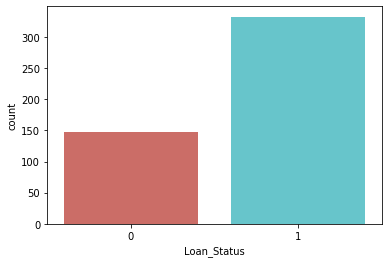

In [21]:
sns.countplot(x=train['Loan_Status'], palette = 'hls')
plt.show()

- More people got their loans approved than disapproved - there might be an imbalance in our data (to be revisited at a later stage).

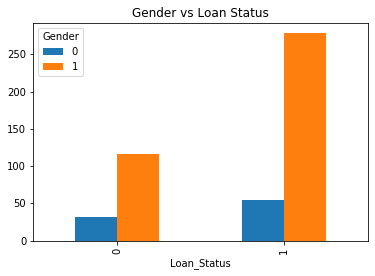

In [22]:
pd.crosstab(train['Loan_Status'],train['Gender']).plot(kind='bar')
plt.title("Gender vs Loan Status")
plt.show()

- Males apply more for loans and a good number of them get their loans approved.

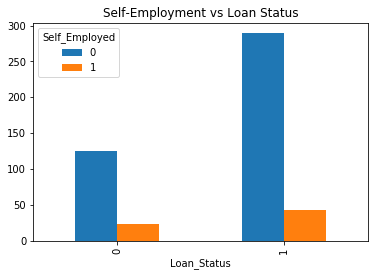

In [23]:
pd.crosstab(train['Loan_Status'],train['Self_Employed']).plot(kind='bar')
plt.title("Self-Employment vs Loan Status")
plt.show()

- Self-employed people apply less for loans.

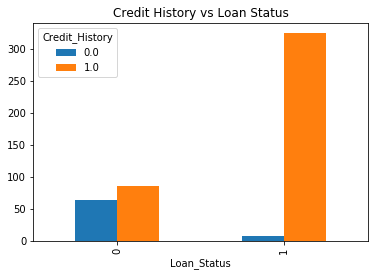

In [24]:
pd.crosstab(train['Loan_Status'],train['Credit_History']).plot(kind='bar')
plt.title("Credit History vs Loan Status")
plt.show()

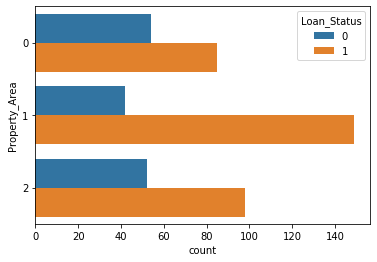

In [25]:
sns.countplot(y='Property_Area', hue = 'Loan_Status', data = train)

- Semiurban people get more loans approved than rural or urban do. 
- Rural people get their loans approved less frequently. 

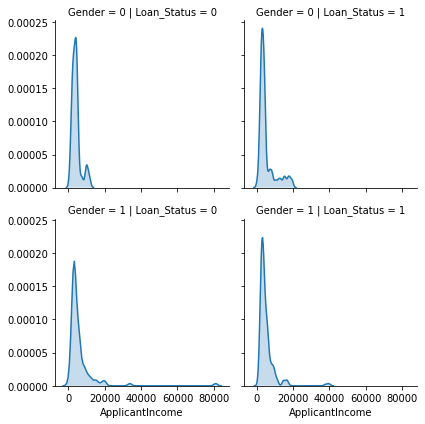

In [26]:
g = sns.FacetGrid(train, row = 'Gender', col = 'Loan_Status')
g.map(sns.kdeplot, 'ApplicantIncome', shade = True)

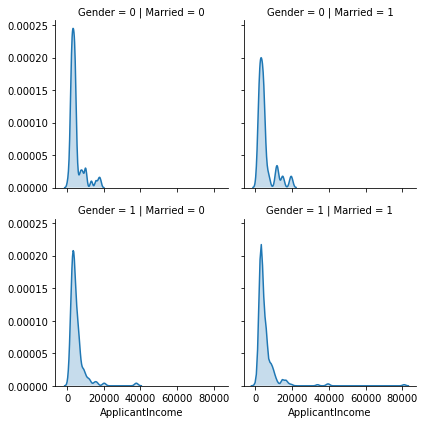

In [27]:
g = sns.FacetGrid(train, row = 'Gender', col = 'Married')
g.map(sns.kdeplot, 'ApplicantIncome', shade = True)

- Interestingly, our income outlier (income of 80,000) is a married male and he did not get his loan approved. 
- It looks like married males have higher income than unmarried ones. 

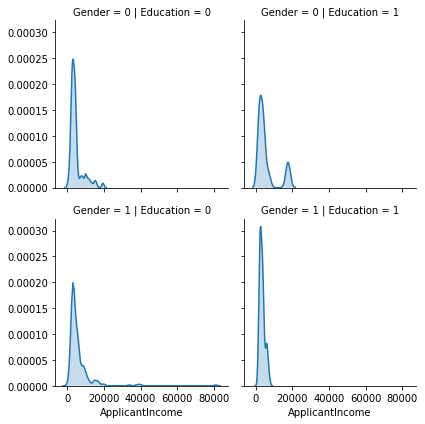

In [28]:
g = sns.FacetGrid(train, row = 'Gender', col = 'Education')
g.map(sns.kdeplot, 'ApplicantIncome', shade = True)

- Males (1) with education (0) have a higher income distribution than males with who are not graduates.

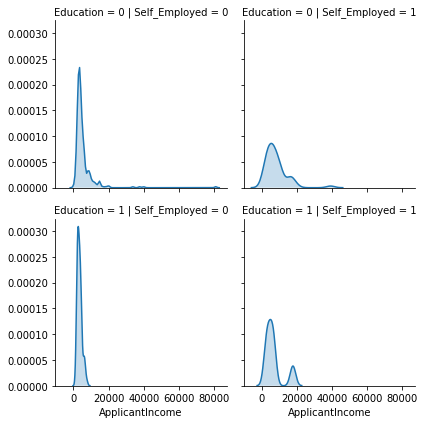

In [29]:
g = sns.FacetGrid(train, row = 'Education', col = 'Self_Employed')
g.map(sns.kdeplot, 'ApplicantIncome', shade = True)

- Graduates (0) who are not self-employed (0) tend to have higher income than graduates who are self-employed.

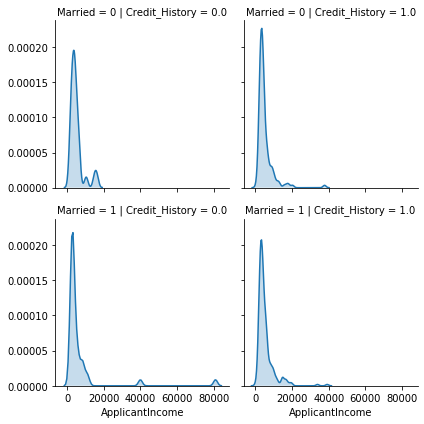

In [30]:
g = sns.FacetGrid(train, row = 'Married', col = 'Credit_History')
g.map(sns.kdeplot, 'ApplicantIncome', shade = True)

- Whether married or unmarried, people with credit history have a higher income. Interestingly, our outlier is a person who does not have a credit history, so that can explain why he did not get the loan.

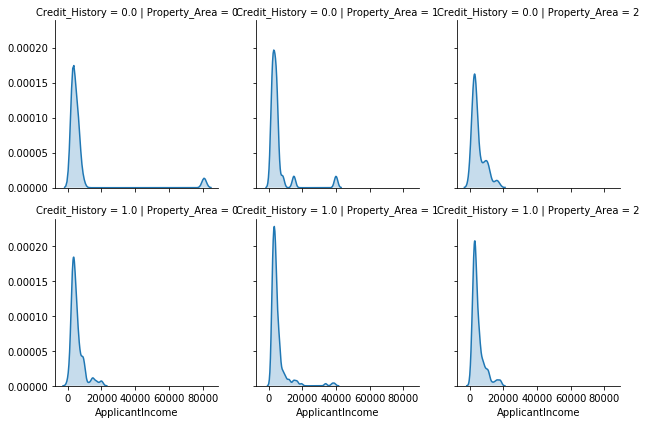

In [31]:
g = sns.FacetGrid(train, row = 'Credit_History', col = 'Property_Area')
g.map(sns.kdeplot, 'ApplicantIncome', shade = True)

 - It looks like people who have a credit history and live in semi-urban areas have a higher income distribution.

### MODEL BUILDING

- This is a classification problem, because we want to either approve or disapprove a loan to a particular customer. Let us try implementing a logistic regression first.
- Depending on the accuracy obtained, we can further determine whether we need a better model, such as a decision tree.
- Given the fact that we have a lot of factors that do not significantly contribute to loan status (at least on face value), we might want to explore feature engineering techniques at a later stage.
- Also, it seems like we might have imbalanced data - let's think about how we plan to handle it.

In [32]:
X = train.drop('Loan_Status', axis=1)
y = train['Loan_Status']

In [33]:
# normalize our features

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#### Logistic Regression Part I

In [34]:
log_reg = LogisticRegression()

In [35]:
# Use cross_val_score to automatically split, fit and score

scores = sklearn.model_selection.cross_val_score(log_reg, X_std, y, cv=10)
print(scores)
print('average score: {}'.format(scores.mean()))

[0.79166667 0.8125     0.77083333 0.79166667 0.77083333 0.77083333
 0.83333333 0.85416667 0.8125     0.83333333]
average score: 0.8041666666666668


- Judging from the accuracy score, we might need to either consider more robust models or perform some feature engineering on our data.

#### Random Forest

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X_std, y, test_size=0.3, random_state=42)

In [37]:
rfc=RandomForestClassifier(random_state=42)

In [38]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [39]:
random_rfc = RandomizedSearchCV(estimator = rfc, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [40]:
random_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [41]:
random_rfc.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 8,
 'bootstrap': True}

In [42]:
rfc1=RandomForestClassifier(random_state=42, n_estimators= 500, max_depth=8, bootstrap = True, max_features = 'auto',min_samples_leaf=4, min_samples_split=2)

In [43]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [44]:
pred=rfc1.predict(X_valid)

In [45]:
print("Accuracy for Random Forest on CV data: ",metrics.accuracy_score(y_valid,pred))

Accuracy for Random Forest on CV data:  0.7986111111111112


- We can see that the accuracy score only decreased with the selection of a different model.

#### Feature Engineering

Let's consider: 
- dropping some features which have low correlation with the target variable;
- inventing new features;
- getting rid of our outlier in the applicant income category;
- dealing with the imbalance in our data by using different models that penalize the imbalance. 

In [46]:
corr_matrix

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.000000,0.349424,0.217510,0.059245,0.002761,0.032644,0.156171,0.098975,0.088704,0.022447,0.000204,0.064504
Married,0.349424,1.000000,0.386367,0.001652,0.015674,0.036717,0.102950,0.183442,0.107504,0.029095,0.038653,0.112321
Dependents,0.217510,0.386367,1.000000,0.028608,0.045754,0.131139,0.000318,0.172780,0.096361,0.026651,0.001191,0.035428
Education,0.059245,0.001652,0.028608,1.000000,0.005085,0.131172,0.074499,0.172780,0.102168,0.056656,0.055005,0.068437
Self_Employed,0.002761,0.015674,0.045754,0.005085,1.000000,0.170785,0.001509,0.120389,0.034852,0.023568,0.050797,0.034715
ApplicantIncome,0.032644,0.036717,0.131139,0.131172,0.170785,1.000000,0.112588,0.495310,0.010838,0.056152,0.053160,0.043152
CoapplicantIncome,0.156171,0.102950,0.000318,0.074499,0.001509,0.112588,1.000000,0.190740,0.005775,0.008692,0.006540,0.049020
LoanAmount,0.098975,0.183442,0.172780,0.172780,0.120389,0.495310,0.190740,1.000000,0.050867,0.040773,0.109685,0.071753
Loan_Amount_Term,0.088704,0.107504,0.096361,0.102168,0.034852,0.010838,0.005775,0.050867,1.000000,0.032937,0.058656,0.007798
Credit_History,0.022447,0.029095,0.026651,0.056656,0.023568,0.056152,0.008692,0.040773,0.032937,1.000000,0.003013,0.529390


Seems like we can drop the following variables with a very low correlation with y:
 - loan amount term;
 - applicant and coapplicant income;
 - property area;
 - dependents and self-employed. 
 
But before we do that, let's consider what additional features we can invent:

In [47]:
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
train['payment_per_month'] = train['LoanAmount']/train['Loan_Amount_Term']

In [48]:
train.drop(['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome', 'Property_Area', 'Self_Employed', 'Dependents'], axis = 1, inplace = True)

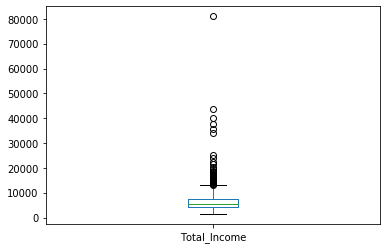

In [49]:
train['Total_Income'].plot(kind='box')
plt.show()

In [50]:
# outlier removal
train[train['Total_Income']>80000].index.values

array([409], dtype=int64)

In [51]:
train.drop(index=409, inplace=True)

#### Logistic Regression Part II

In [52]:
X_new = train.drop('Loan_Status', axis=1)
y_new = train['Loan_Status']

In [53]:
# normalize our features

scaler = StandardScaler()
X_std = scaler.fit_transform(X_new)

In [54]:
log_reg2 = LogisticRegression()

In [55]:
# Use cross_val_score to automatically split, fit and score

scores = sklearn.model_selection.cross_val_score(log_reg2, X_std, y_new, cv=10)
print(scores)
print('average score: {}'.format(scores.mean()))

[0.79166667 0.8125     0.77083333 0.77083333 0.77083333 0.77083333
 0.83333333 0.875      0.8125     0.85106383]
average score: 0.8059397163120566


- There is a very slight improvement in the average score.
- Perhaps using different models and adding penalties for imbalance might improve the score, so let's explore that.

#### Penalized SVM

In [56]:
from sklearn.svm import SVC

In [57]:
svc_ = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X_std, y_new, test_size=0.3, random_state=42)

In [60]:
svc_.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [61]:
pred_y = svc_.predict(X_valid)

In [62]:
print(metrics.accuracy_score(y_valid, pred_y))

0.7916666666666666


- With the models and techniques we've tried so far, the best accuracy score was obtained by the logistic regression. 
- Now we can use it to predict the labels of the test data.